# 1. Setup

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since I'll be training a large neural network it's best to take advantage of this (in this case I'll attach a GPU), otherwise training will take a very long time.


In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, I need to identify and specify the GPU as the device. Later, in my training loop, I will load data onto the device. 

In [2]:
# We need the GPU: Tesla P100-PCIE-16GB
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers

     |████████████████████████████████| 1.3MB 8.6MB/s 
     |████████████████████████████████| 1.1MB 29.6MB/s 
     |████████████████████████████████| 890kB 19.4MB/s 
     |████████████████████████████████| 2.9MB 52.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ced66aa7ed83946e7dc652ebd7f087d89d04ed88f3550f3c31ba3a4f85fff43c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.


# 2. Loading Dataset


## 2.1. Download & Extract

In [ ]:
import pandas as pd

In [ ]:
Geo_analyse = pd.read_csv("/content/train_moins_sample.csv")

Geo_analyse.isnull().values.any()

Geo_analyse.shape

(2317, 2)

## 2.2. Parse

Here are five sentences of the dataset

In [ ]:
Geo_analyse.head(5)

sentences  labels
0                 — Comme tu voudras, répondit-elle.       0
1  Ce n’est plus moi, c’est elle qui couche avec ...       0
2                               Un parent, je crois.       0
3                           je m’y attendais un peu.       0
4                            Comment la faire taire?       0



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
# Get the lists of sentences and their labels.
sentences = Geo_analyse.sentences.values
labels = Geo_analyse.labels.values

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "multilingual cased" version here.


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',do_lower_case=False)

Loading BERT tokenizer...


Apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  — Comme tu voudras, répondit-elle.
Tokenized:  ['[UNK]', 'Comme', 'tu', 'vo', '##udra', '##s', ',', 'répond', '##it', '-', 'elle', '.']
Token IDs:  [100, 27113, 13055, 12556, 81216, 10107, 117, 108811, 10486, 118, 11117, 119]


When I actually convert all of my sentences, I'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before I can do that, though, I need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that I'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

I am required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

At the end of every sentence, I need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

**`[CLS]`**

For classification tasks, I must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.



### Sentence Length & Attention Mask



The sentences in my dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?! Again, I don't currently know why).







## 3.2. Sentences to IDs

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but I need to do padding, so I
                        # can't use these features.
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  — Comme tu voudras, répondit-elle.
Token IDs: [101, 100, 27113, 13055, 12556, 81216, 10107, 117, 108811, 10486, 118, 11117, 119, 102]


## 3.3. Padding & Truncating

Pad and truncate my sequences so that they all have the same length, `MAX_LEN`.

First, what's the maximum sentence length in our dataset?

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  238


Given that, I choose MAX_LEN = 256 and apply the padding.

In [ ]:
# I'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 256 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 238...
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


## 3.4. Attention Masks

The attention mask simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

## 3.5. Training & Validation Split


Divide the training set to use 90% for training and 10% for validation.

In [ ]:
# Use train_test_split to split data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

## 3.6. Converting to PyTorch Data Types

My model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for my model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

I'll also create an iterator for the dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know the batch size for training, so I specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 4. Train Classification Model

Now that input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, I first want to modify the pre-trained BERT model to give outputs for classification, and then I want to continue training the model on the dataset until that the entire model, end-to-end, is well-suited for my task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one I'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-multilingual-cased" means BERT base architecture with cased vocabulary for 104 languages. "bert-base-multilingual-uncased" means BERT base architecture with uncased vocabulary for 102 languages.

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/pretrained_models.html), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

We can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 4.2. Optimizer & Learning Rate Scheduler

Now that I have my model loaded I need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (I chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (I'll use 2e-5).
- Number of epochs: 2, 3, 4  (I'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is the training loop. There's a lot going on, but fundamentally for each pass in this loop I have a trianing phase and a validation phase. At each pass I need to:

Training loop:
- Unpack data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress


Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


The training loop

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so I can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from the dataloader. 
        #
        # As I unpack the batch, I'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because I
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so I need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that I can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure the performance on
    # the validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:51.

  Average training loss: 0.09
  Training epcoh took: 0:01:24

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:53.

  Average training loss: 0.01
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:56.

  Average training loss: 0.01
  Training epcoh took: 0:01:31

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:56.

  Average training loss: 0.00
  Training epcoh took: 0:01:32

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

Training complete!


Plot the training loss over all batches:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


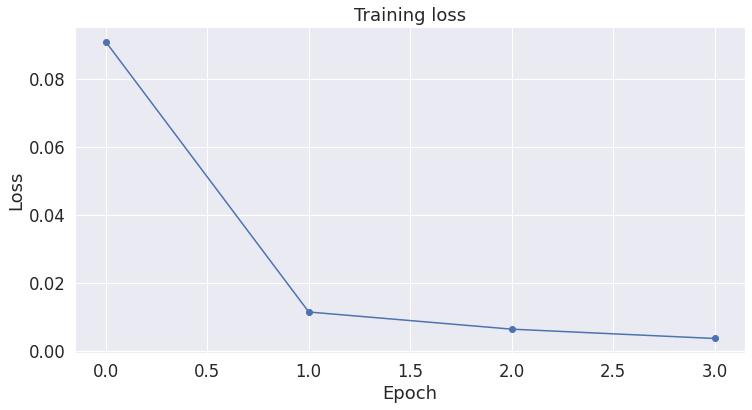

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 5. Performance On Test Set

Now I'll load the holdout dataset and prepare inputs just as I did with the training set. Then I'll evaluate predictions using  many matrics like ( F1_score, Precision, Recall, accuracy...)

### 5.1. Data Preparation


I'll need to apply all of the same steps that I did for the training data to prepare the test data set.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/test_fin_07_06.csv")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentences.values
labels = df.labels.values




Number of test sentences: 2,412



In [ ]:
df['labels'].value_counts()

0    1871
1     541
Name: labels, dtype: int64

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                        dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluate on Test Set



With the test set prepared, I can apply the fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_test , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
# Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from the dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    #print(logits)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    #print(logits)
    
    # Store predictions and true labels
    predictions_test.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,412 test sentences...
    DONE.


In [ ]:
predictions_test[0][0]

array([ 4.3997846, -3.7260323], dtype=float32)

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.labels.sum(), len(df.labels), (df.labels.sum() / len(df.labels) * 100.0)))

Positive samples: 541 of 2412 (22.43%)


We use MCC here because the classes are imbalanced:


In [ ]:
from sklearn.metrics import *

matthews_set = []
pred_labels = []
f1_score_met = []
roc_auc_score_met = []
precision_score_met = []
recall_score_met = []
confusion_matrix_met =[]
precision_recall_curve_met =[]
accuracy_score_met = []
# Evaluate each test batch using many matrics
print('Calculating the matrics for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions_test[i], axis=1).flatten()
  pred_labels.append(pred_labels_i)

# Calculate and store the similarity for this batch depending on accuracy
  accuracy_score_i = accuracy_score(pred_labels_i, true_labels[i])
  accuracy_score_met.append(accuracy_score_i)

# Calculate and store the similarity for this batch depending on F1_score
  f1_score_i = f1_score(pred_labels_i, true_labels[i], average="binary")
  f1_score_met.append(f1_score_i)


  confusion_matrix_i = confusion_matrix(pred_labels_i, true_labels[i])
  confusion_matrix_met.append(confusion_matrix_i)


# Calculate and store the similarity for this batch depending on precision, recall, and roc_auc_score
  precision_recall_curve_i = precision_recall_curve(pred_labels_i, true_labels[i])
  precision_recall_curve_met.append(precision_recall_curve_i)

  precision_score_i = precision_score(pred_labels_i, true_labels[i], average="binary")
  precision_score_met.append(precision_score_i)

  roc_auc_score_i = roc_auc_score(pred_labels_i, true_labels[i])
  roc_auc_score_met.append(roc_auc_score_i)

  recall_score_i = recall_score(pred_labels_i, true_labels[i], average="binary")
  recall_score_met.append(recall_score_i)

  # Calculate and store the coef for this batch depending on mathew
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
#Calculate the number of Tp,Tn,Fp and Fn in the predictions
tns = 0
fps = 0
fns = 0
tps = 0
for i in range(len(predictions_test)):
    pred_labels_i_fin = np.argmax(predictions_test[i], axis=1).flatten()
    tn, fp, fn, tp = confusion_matrix(pred_labels_i_fin, true_labels[i]).ravel()
    tns = tns + tn
    fps = fps + fp
    fns = fns + fn
    tps = tps + tp

In [ ]:
#Calculate the number of Tp,Tn,Fp and Fn in the predictions by confusion matrix
sum(confusion_matrix_met)

array([[1797,    0],
       [  74,  541]])

In [ ]:
#Sample of true labels in the dataset
true_labels[0]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
#Sample of predicted labels in the predictions list
pred_labels[0]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


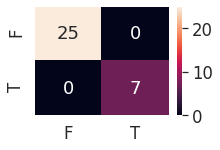

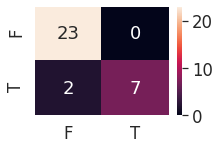

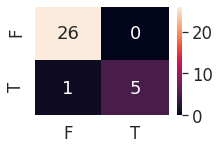

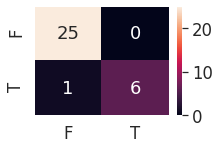

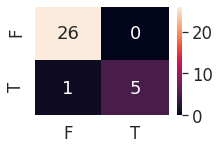

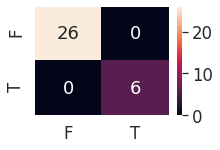

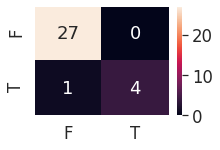

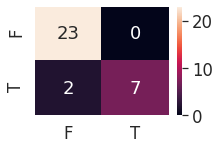

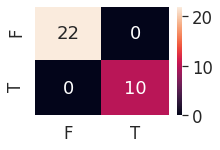

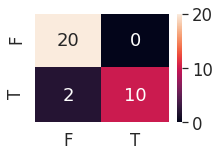

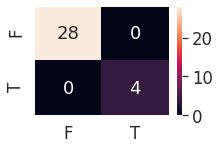

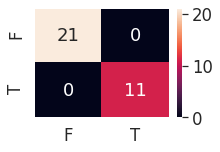

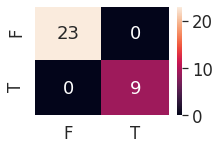

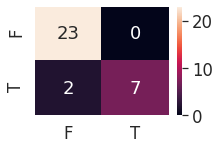

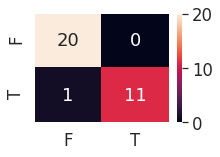

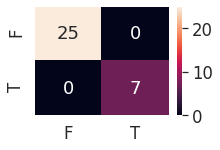

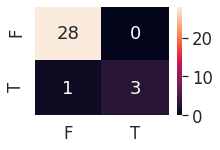

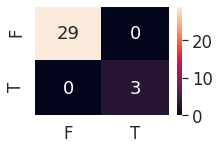

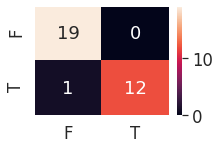

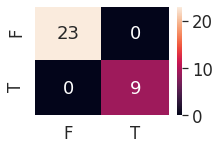

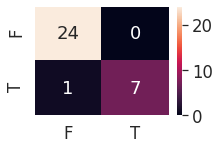

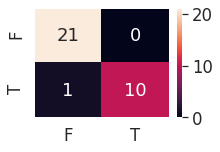

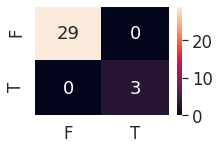

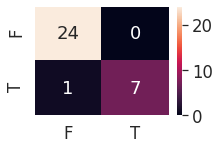

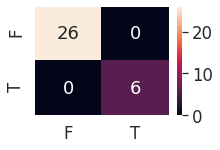

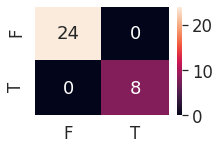

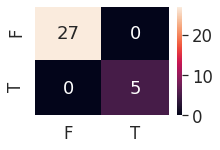

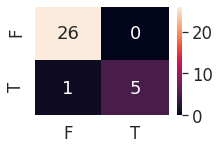

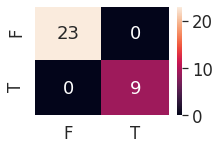

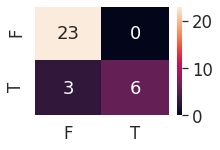

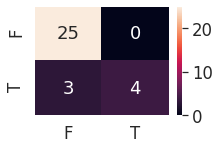

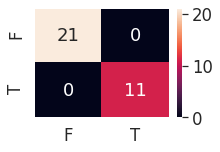

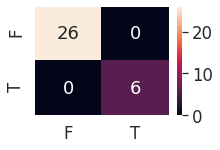

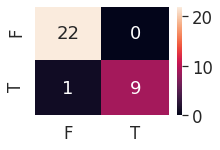

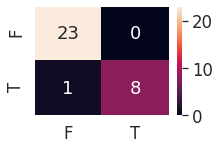

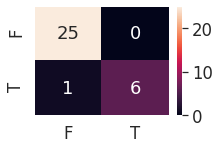

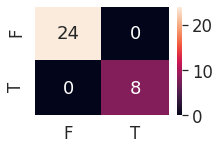

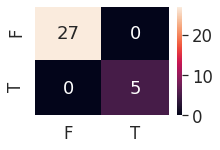

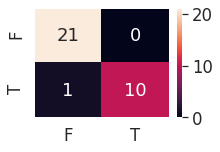

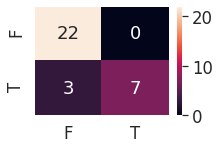

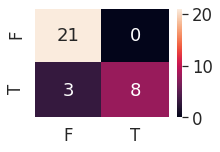

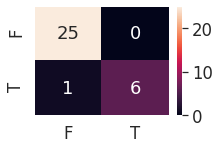

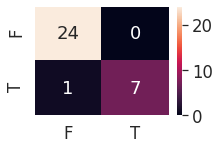

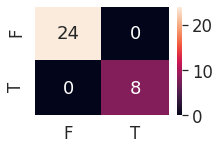

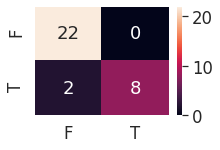

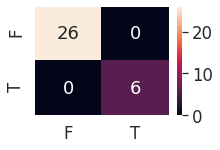

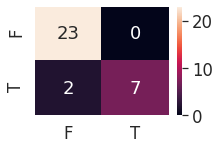

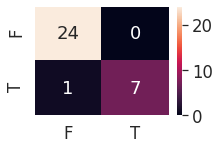

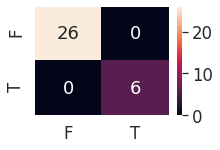

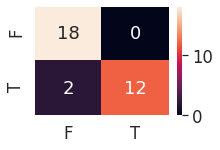

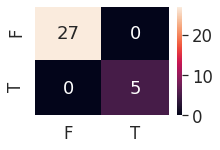

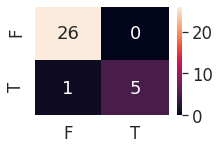

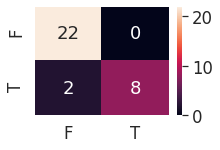

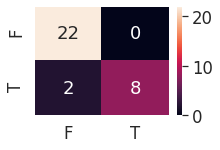

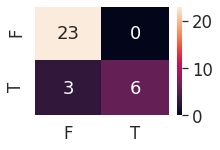

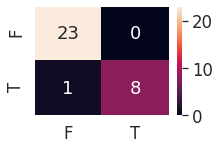

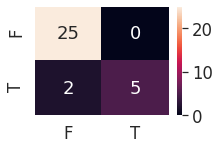

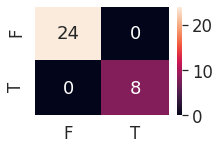

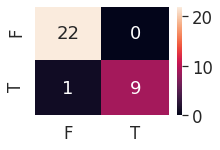

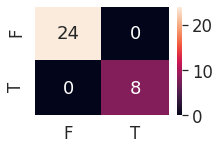

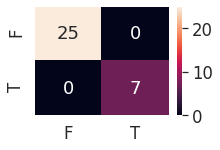

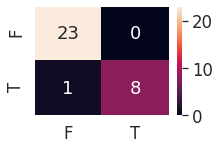

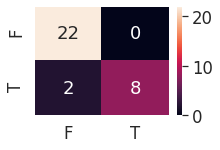

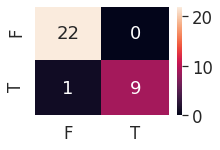

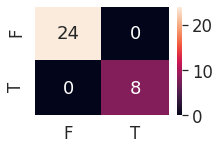

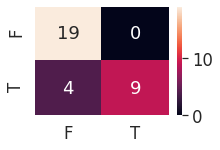

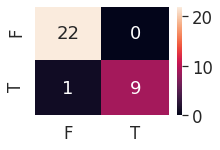

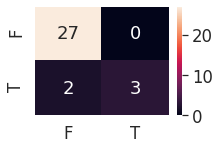

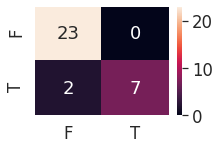

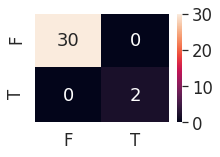

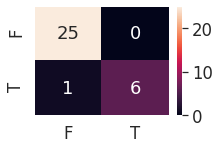

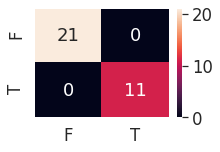

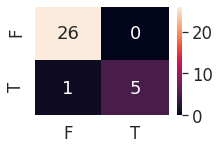

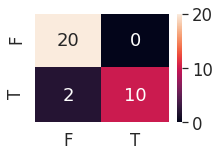

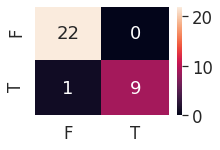

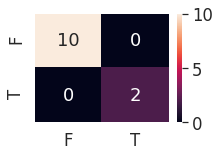

In [ ]:
#Plot the confusion matrix for each batch
for i in range(len(confusion_matrix_met)):
    df_cm = pd.DataFrame(confusion_matrix_met[i], index = [i for i in "FT"],
                  columns = [i for i in "FT"])
    plt.figure(figsize = (3,2))
    sn.heatmap(df_cm, annot=True)

In [ ]:
# Thus in binary classification, the count of true negatives is C0.0, false negatives is C1.0, true positives is C1.1 and false positives is C0.1.
len(confusion_matrix_met)

76

In [ ]:
# importing mean() for calculate the mean of all the lists (precision, recall, f1-score ... ) 
from statistics import mean 
  

In [ ]:
mean(roc_auc_score_met)

0.943560240928662

In [ ]:
mean(recall_score_met)

0.887120481857324

In [ ]:
mean(accuracy_score_met)

0.9695723684210527

In [ ]:
mean(precision_score_met)

1.0

In [ ]:
mean(f1_score_met)

0.9363818332706881

In [ ]:
mean(matthews_set)

0.9219909077922733

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions_test for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.919


#6. Test on an entire novel sentences (the novel "maison")

##Download the novels

We must create a new folder in (content) on colab and we name it (Romans). Then we upload the novels we want

In [ ]:
from os import listdir
from os.path import isfile, join
dir = "/content/Romans"
onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))] # list of novels names(with extentions filename.txt) in the directory path

In [ ]:
onlyfiles[0]

'maison.txt'

In [ ]:
# Put the novels contents in list
content_french = [] #List of lists of sentences of novels
file_content =[]
for file in onlyfiles:
    #file_content.append( file.read )
    f = open('/content/Romans/'+ file)
    #file_content.append(f)
    content_french.append(f.read())

In [ ]:
content_french[0]

'\n\n\nAu milieu de la rue Saint-Denis, presque au coin de la rue du Petit-Lion, existait naguère une de ces maisons précieuses qui donnent aux historiens la facilité de reconstruire par analogie l’ancien Paris. Les murs menaçants de cette bicoque semblaient avoir été bariolés d’hiéroglyphes. Quel autre nom le flâneur pouvait-il donner aux X et aux V que traçaient sur la façade les pièces de bois transversales ou diagonales dessinées dans le badigeon par de petites lézardes parallèles ? Evidemment, au passage de toutes les voitures, chacune de ces solives s’agitait dans sa mortaise. Ce vénérable édifice était surmonté d’un toit triangulaire dont aucun modèle ne se verra bientôt plus à Paris. Cette couverture, tordue par les intempéries du climat parisien, s’avançait de trois pieds sur la rue, autant pour garantir des eaux pluviales le seuil de la porte, que pour abriter le mur d’un grenier et sa lucarne sans appui. Ce dernier étage était construit en planches clouées l’une sur l’autre 

## Transform novels to sentence lists

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Function for split the sentences of text using "re" library
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mme|Mlle|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|St|Mme|Mlle|Mrs|Ms|Dr|Il\s|Elle\s|It\s|Ils\s|Elle\s|Leur\s|Notre\s|Nous\s|On\s|Mais\s|Cependant\s|Ce\s|Cette\s|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    #..... -> .
   # text = re.sub('[.]+', '.', text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [ ]:
splited_sentences= [None] * len(content_french)


In [ ]:
for i in range(len(content_french)):
 splited_sentences[i]=split_into_sentences(content_french[i])



In [ ]:
for i in range(len(splited_sentences)):
    print("nombre de phrases du roman " + onlyfiles[i], len(splited_sentences[i]))

nombre de phrases du roman maison.txt 1010


In [ ]:
test_sentences = [None] * len(splited_sentences)

In [ ]:
#Convert the lists of sentences to ndarray by numpy
for i in range(len(splited_sentences)):
    test_sentences[i] = np.asarray(splited_sentences[i], dtype=np.str)

In [ ]:
onlyfiles[0]

'maison.txt'

In [ ]:
import pandas as pd

#input_ids_test = [None] * len(test_sentences)
#attention_masks = [None] * len()
prediction_dataloader = [None] * len(test_sentences)

for i in range(len(test_sentences)):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    #input_ids_test[i] = [None] * len(test_sentences[i])
    #prediction_dataloader[i] = [None] * len(test_sentences[i])
    input_ids_test = []
    # For every sentence...
    for sent in test_sentences[i]:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    )
        
        input_ids_test.append(encoded_sent)

    # Pad our input tokens
    input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                            dtype="long", truncating="post", padding="post")

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids_test:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    # Convert to tensors.
    prediction_inputs = torch.tensor(input_ids_test)
    prediction_masks = torch.tensor(attention_masks)
    #prediction_labels = torch.tensor(labels)

    # Set the batch size.  
    batch_size = 32  

    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader[i] = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)



In [ ]:
predictions = []
# Prediction on novels
for i in range(len(prediction_dataloader)):
    print('Predicting labels for {:,} test sentences '.format(len(test_sentences[i])) + 'for the novel ' + onlyfiles[i])

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions_i = []

    # Predict 
    for batch in prediction_dataloader[i]:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask= batch
    
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
        #print(outputs[0])
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        #label_ids = b_labels.to('cpu').numpy()
    
        # Store predictions and true labels
        predictions_i.append(logits)
        #print(predictions_i)
    predictions.append(predictions_i)
    #true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,010 test sentences for the novel maison.txt
    DONE.


In [ ]:
pred_labels = []

for j in range(len(prediction_dataloader)):   
    # Evaluate each test batch using Matthew's correlation coefficient
    print('Calculating Matthews Corr. Coef. for each batch of ' + onlyfiles[j])
    pred_labels_i= []
    # For each input batch...
    for i in range(len(prediction_dataloader[j])):
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
        pred_labels_i_j = np.argmax(predictions[j][i], axis=1).flatten()
        pred_labels_i.append(pred_labels_i_j)
    pred_labels.append(pred_labels_i)

Calculating Matthews Corr. Coef. for each batch of maison.txt


In [ ]:
pred_rom_list = []
for pred_rom in range(len(pred_labels)):
    pred_rom_i_list = []
    for  pred_bat in range(len(pred_labels[pred_rom])):
        pred_rom_i_list.append(pred_labels[pred_rom][pred_bat].tolist())
    pred_rom_list.append(pred_rom_i_list)

In [ ]:
roms_list_fin= []
for i in range(len(pred_rom_list)):
    flat_list = [item for sublist in pred_rom_list[i] for item in sublist]
    roms_list_fin.append(flat_list)


In [ ]:
# on va voir dans les résultats parfois 1 pour une phrase qui n'indique pas sentences Geo.
# mais cette phrase est liée soit à une phrase Geo avant soit à une phrase Geo après
import pandas
for i in range(len(onlyfiles)):
    df = pandas.DataFrame(data={"sentences": test_sentences[i], "labels": roms_list_fin[i]})
    df.to_csv("./resultats_" + onlyfiles[i] + ".csv", sep=',',index=False)


# Using Bert uncased

# 1 Loading Dataset


## 1.1. Download & Extract

In [ ]:
import pandas as pd

In [ ]:
Geo_analyse = pd.read_csv("/content/train_moins_sample.csv")

Geo_analyse.isnull().values.any()

Geo_analyse.shape

(2317, 2)

## 1.2. Parse

Here are five sentences of the dataset

In [ ]:
Geo_analyse.head(5)

sentences  labels
0                 — Comme tu voudras, répondit-elle.       0
1  Ce n’est plus moi, c’est elle qui couche avec ...       0
2                               Un parent, je crois.       0
3                           je m’y attendais un peu.       0
4                            Comment la faire taire?       0



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
# Get the lists of sentences and their labels.
sentences = Geo_analyse.sentences.values
labels = Geo_analyse.labels.values

#2 Tokenization and Input Formating

## 2.1. BERT Tokenizer (uncased)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased',do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  — Comme tu voudras, répondit-elle.
Tokenized:  ['[UNK]', 'comme', 'tu', 'vo', '##udra', '##s', ',', 'rep', '##ond', '##it', '-', 'elle', '.']
Token IDs:  [100, 11043, 10689, 11821, 94698, 10107, 117, 37090, 21510, 10517, 118, 10725, 119]


## 2.2. Sentences to IDs

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  — Comme tu voudras, répondit-elle.
Token IDs: [101, 100, 11043, 10689, 11821, 94698, 10107, 117, 37090, 21510, 10517, 118, 10725, 119, 102]


## 2.3. Padding & Truncating

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  232


Given that, let's choose MAX_LEN = 256 and apply the padding.

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 256 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 205...
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Done.


## 2.4. Attention Masks

In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

## 3.5. Training & Validation Split


In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

## 3.6. Converting to PyTorch Data Types

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


# 3. Train Classification Model

## 3.1. BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (105879, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 3.2. Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 3.3. Training Loop

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:51.

  Average training loss: 0.15
  Training epcoh took: 0:01:23

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:53.

  Average training loss: 0.03
  Training epcoh took: 0:01:27

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:55.

  Average training loss: 0.01
  Training epcoh took: 0:01:29

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     66.    Elapsed: 0:00:56.

  Average training loss: 0.00
  Training epcoh took: 0:01:31

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:04

Training complete!


Let's take a look at our training loss over all batches:

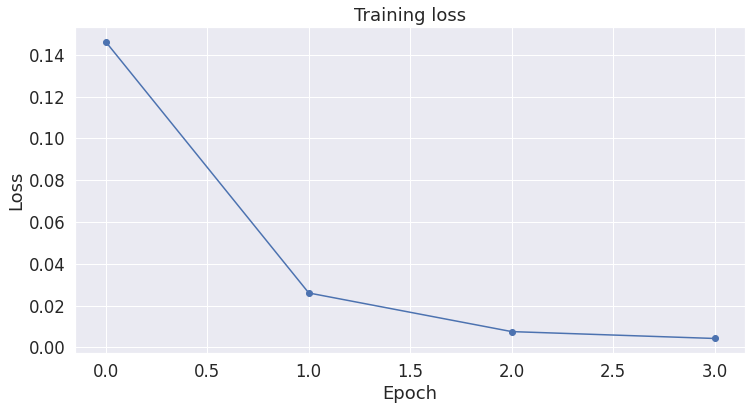

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# 4. Performance On Test Set

### 4.1. Data Preparation


In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/test_fin_07_06.csv")

#df = df.sample(3121)
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentences.values
labels = df.labels.values




Number of test sentences: 2,412



In [ ]:
df['labels'].value_counts()

0    1871
1     541
Name: labels, dtype: int64

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                        dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_test , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
# Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    #print(logits)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    #print(logits)
    
    # Store predictions and true labels
    predictions_test.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,412 test sentences...
    DONE.


In [ ]:
predictions_test[0][0]

array([ 3.913034, -4.178549], dtype=float32)

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.labels.sum(), len(df.labels), (df.labels.sum() / len(df.labels) * 100.0)))

Positive samples: 541 of 2412 (22.43%)


In [ ]:
from sklearn.metrics import *

matthews_set = []
pred_labels = []
f1_score_met = []
roc_auc_score_met = []
precision_score_met = []
recall_score_met = []
confusion_matrix_met =[]
precision_recall_curve_met =[]
accuracy_score_met = []
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions_test[i], axis=1).flatten()
  pred_labels.append(pred_labels_i)

  accuracy_score_i = accuracy_score(pred_labels_i, true_labels[i])
  accuracy_score_met.append(accuracy_score_i)

  f1_score_i = f1_score(pred_labels_i, true_labels[i], average="binary")
  f1_score_met.append(f1_score_i)

  confusion_matrix_i = confusion_matrix(pred_labels_i, true_labels[i])
  confusion_matrix_met.append(confusion_matrix_i)

  precision_recall_curve_i = precision_recall_curve(pred_labels_i, true_labels[i])
  precision_recall_curve_met.append(precision_recall_curve_i)

  precision_score_i = precision_score(pred_labels_i, true_labels[i], average="binary")
  precision_score_met.append(precision_score_i)

  roc_auc_score_i = roc_auc_score(pred_labels_i, true_labels[i])
  roc_auc_score_met.append(roc_auc_score_i)

  recall_score_i = recall_score(pred_labels_i, true_labels[i], average="binary")
  recall_score_met.append(recall_score_i)

  # Calculate and store the coef for this batch depending on mathew
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [ ]:
#Calculate the number of Tp,Tn,Fp and Fn in the predictions
tns = 0
fps = 0
fns = 0
tps = 0
for i in range(len(predictions_test)):
    pred_labels_i_fin = np.argmax(predictions_test[i], axis=1).flatten()
    tn, fp, fn, tp = confusion_matrix(pred_labels_i_fin, true_labels[i]).ravel()
    tns = tns + tn
    fps = fps + fp
    fns = fns + fn
    tps = tps + tp

In [ ]:
#Calculate the number of Tp,Tn,Fp and Fn in the predictions by confusion matrix
sum(confusion_matrix_met)

array([[1801,    2],
       [  70,  539]])

In [ ]:
#Sample of true labels in the dataset
true_labels[0]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
#Sample of predicted labels in the predictions list
pred_labels[0]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


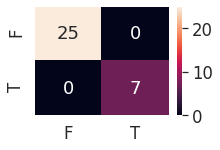

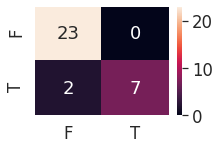

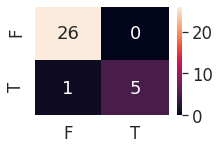

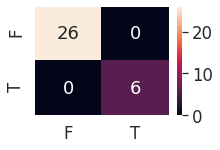

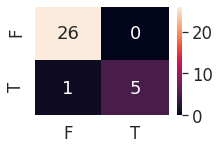

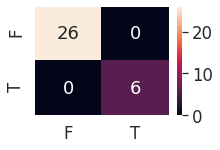

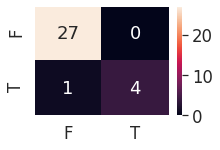

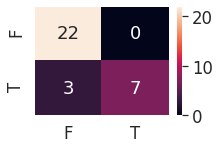

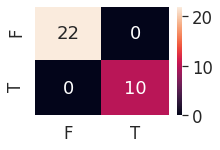

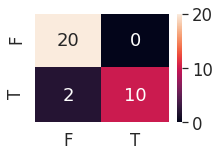

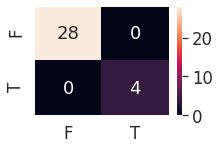

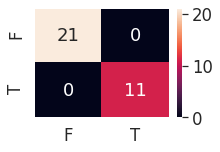

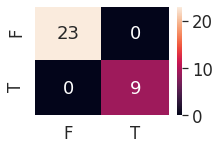

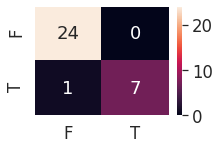

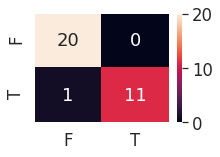

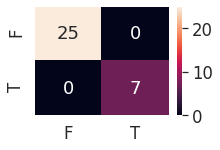

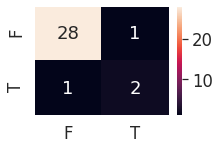

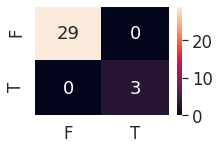

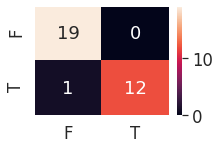

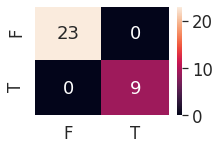

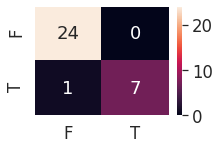

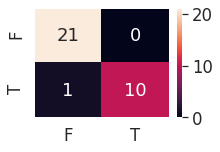

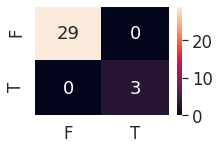

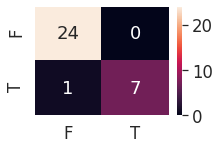

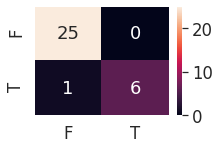

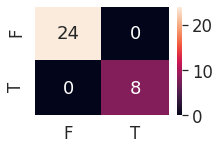

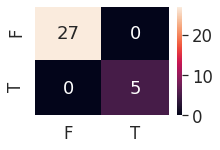

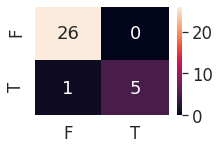

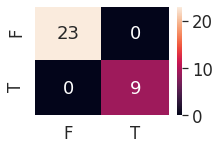

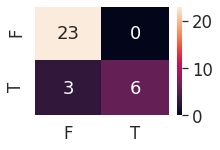

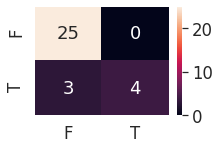

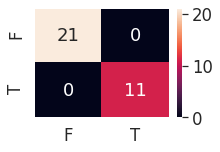

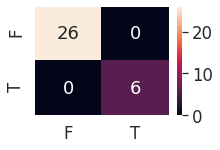

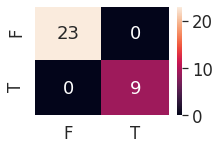

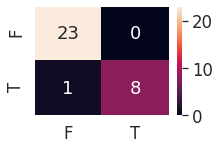

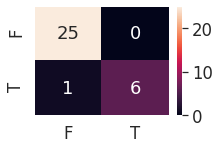

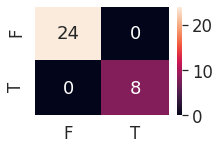

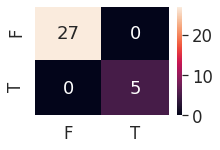

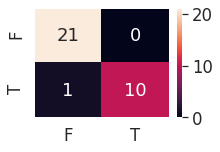

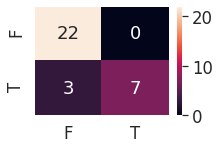

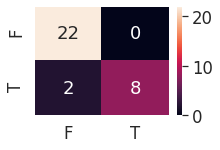

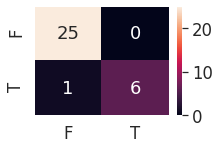

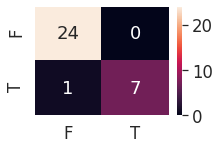

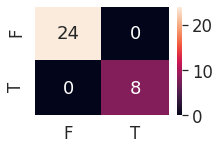

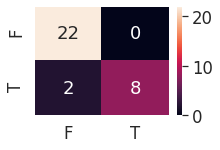

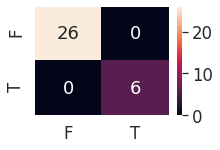

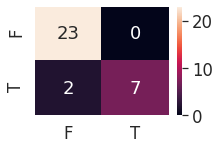

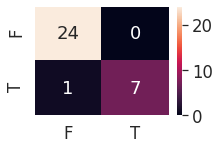

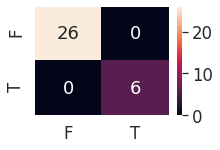

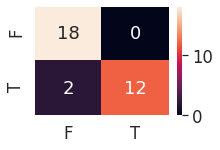

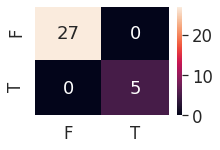

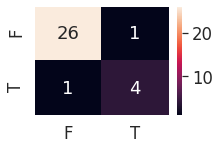

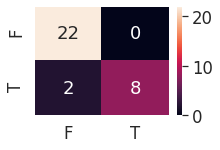

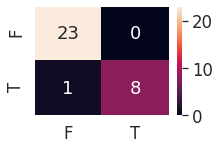

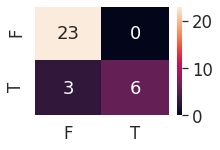

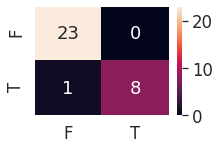

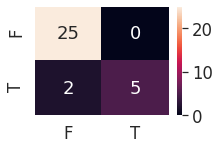

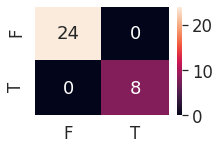

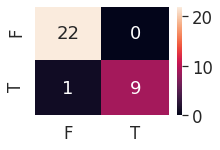

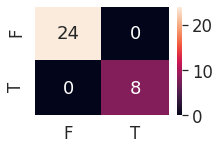

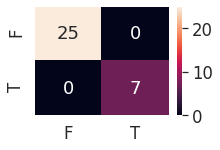

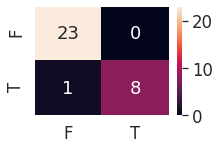

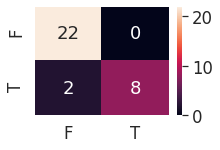

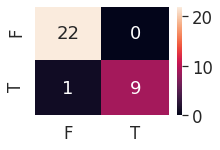

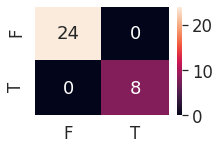

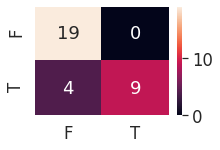

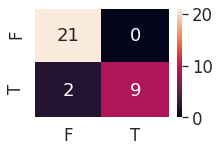

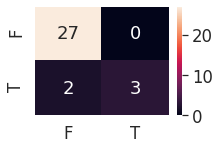

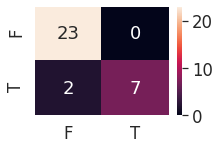

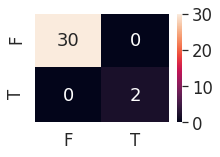

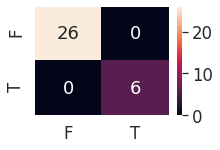

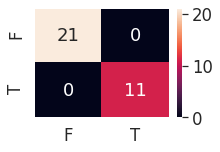

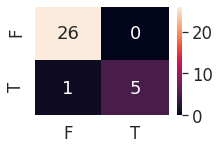

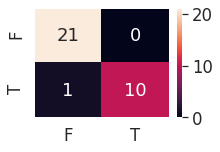

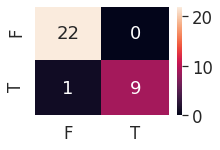

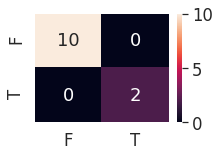

In [ ]:
#Plot the confusion matrix for each batch
for i in range(len(confusion_matrix_met)):
    df_cm = pd.DataFrame(confusion_matrix_met[i], index = [i for i in "FT"],
                  columns = [i for i in "FT"])
    plt.figure(figsize = (3,2))
    sn.heatmap(df_cm, annot=True)

In [ ]:
# Thus in binary classification, the count of true negatives is C0.0, false negatives is C1.0, true positives is C1.1 and false positives is C0.1.
len(confusion_matrix_met)

76

In [ ]:
# importing mean() for calculate the mean of all the lists (precision, recall, f1-score ... ) 
from statistics import mean 
  

In [ ]:
mean(roc_auc_score_met)

0.9450712322479564

In [ ]:
mean(recall_score_met)

0.8910835144387776

In [ ]:
mean(accuracy_score_met)

0.9703947368421053

In [ ]:
mean(precision_score_met)

0.9929824561403509

In [ ]:
mean(f1_score_met)

0.9354850323637031

In [ ]:
mean(matthews_set)

0.9212690080028949

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions_test for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.921


#5. Test sample of novels sentences

##Download the novels

We must create a new folder in (content) on colab and we name it (Romans). Then we upload the novels we want

In [ ]:
from os import listdir
from os.path import isfile, join
dir = "/content/Romans"
onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))] # list of novels names(with extentions filename.txt) in the directory path

In [ ]:
onlyfiles[0]

'maison.txt'

In [ ]:
# Put the novels contents in list
content_french = [] #List of lists of sentences of novels
file_content =[]
for file in onlyfiles:
    #file_content.append( file.read )
    f = open('/content/Romans/'+ file)
    #file_content.append(f)
    content_french.append(f.read())

In [ ]:
content_french[0]

'\n\n\nAu milieu de la rue Saint-Denis, presque au coin de la rue du Petit-Lion, existait naguère une de ces maisons précieuses qui donnent aux historiens la facilité de reconstruire par analogie l’ancien Paris. Les murs menaçants de cette bicoque semblaient avoir été bariolés d’hiéroglyphes. Quel autre nom le flâneur pouvait-il donner aux X et aux V que traçaient sur la façade les pièces de bois transversales ou diagonales dessinées dans le badigeon par de petites lézardes parallèles ? Evidemment, au passage de toutes les voitures, chacune de ces solives s’agitait dans sa mortaise. Ce vénérable édifice était surmonté d’un toit triangulaire dont aucun modèle ne se verra bientôt plus à Paris. Cette couverture, tordue par les intempéries du climat parisien, s’avançait de trois pieds sur la rue, autant pour garantir des eaux pluviales le seuil de la porte, que pour abriter le mur d’un grenier et sa lucarne sans appui. Ce dernier étage était construit en planches clouées l’une sur l’autre 

## Transform novels to sentence lists

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Fonction pour diviser le texte aux phrases
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [ ]:
splited_sentences= [None] * len(content_french)


In [ ]:
for i in range(len(content_french)):
 splited_sentences[i]=split_into_sentences(content_french[i])



In [ ]:
for i in range(len(splited_sentences)):
    print("nombre de phrases du roman " + onlyfiles[i], len(splited_sentences[i]))

nombre de phrases du roman maison.txt 1010


In [ ]:
test_sentences = [None] * len(splited_sentences)

In [ ]:
#Convert the lists of sentences to ndarray by numpy
for i in range(len(splited_sentences)):
    test_sentences[i] = np.asarray(splited_sentences[i], dtype=np.str)

In [ ]:
onlyfiles[0]

'maison.txt'

In [ ]:
import pandas as pd

#input_ids_test = [None] * len(test_sentences)
#attention_masks = [None] * len()
prediction_dataloader = [None] * len(test_sentences)

for i in range(len(test_sentences)):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    #input_ids_test[i] = [None] * len(test_sentences[i])
    #prediction_dataloader[i] = [None] * len(test_sentences[i])
    input_ids_test = []
    # For every sentence...
    for sent in test_sentences[i]:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    )
        
        input_ids_test.append(encoded_sent)

    # Pad our input tokens
    input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, 
                            dtype="long", truncating="post", padding="post")

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids_test:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    # Convert to tensors.
    prediction_inputs = torch.tensor(input_ids_test)
    prediction_masks = torch.tensor(attention_masks)
    #prediction_labels = torch.tensor(labels)

    # Set the batch size.  
    batch_size = 32  

    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader[i] = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)



In [ ]:
predictions = []
# Prediction on novels
for i in range(len(prediction_dataloader)):
    print('Predicting labels for {:,} test sentences '.format(len(test_sentences[i])) + 'for the novel ' + onlyfiles[i])

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions_i = []

    # Predict 
    for batch in prediction_dataloader[i]:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask= batch
    
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
        #print(outputs[0])
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        #label_ids = b_labels.to('cpu').numpy()
    
        # Store predictions and true labels
        predictions_i.append(logits)
        #print(predictions_i)
    predictions.append(predictions_i)
    #true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,010 test sentences for the novel maison.txt
    DONE.


In [ ]:
pred_labels = []

for j in range(len(prediction_dataloader)):   
    # Evaluate each test batch using Matthew's correlation coefficient
    print('Calculating Matthews Corr. Coef. for each batch of ' + onlyfiles[j])
    pred_labels_i= []
    # For each input batch...
    for i in range(len(prediction_dataloader[j])):
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
        pred_labels_i_j = np.argmax(predictions[j][i], axis=1).flatten()
        pred_labels_i.append(pred_labels_i_j)
    pred_labels.append(pred_labels_i)

Calculating Matthews Corr. Coef. for each batch of maison.txt


In [ ]:
pred_rom_list = []
for pred_rom in range(len(pred_labels)):
    pred_rom_i_list = []
    for  pred_bat in range(len(pred_labels[pred_rom])):
        pred_rom_i_list.append(pred_labels[pred_rom][pred_bat].tolist())
    pred_rom_list.append(pred_rom_i_list)

In [ ]:
roms_list_fin= []
for i in range(len(pred_rom_list)):
    flat_list = [item for sublist in pred_rom_list[i] for item in sublist]
    roms_list_fin.append(flat_list)


In [ ]:
# on va voir dans les résultats parfois 1 pour une phrase qui n'indique pas sentences Geo.
# mais cette phrase est liée soit à une phrase Geo avant soit à une phrase Geo après
import pandas
for i in range(len(onlyfiles)):
    df = pandas.DataFrame(data={"sentences": test_sentences[i], "labels": roms_list_fin[i]})
    df.to_csv("./resultats_" + onlyfiles[i] + ".csv", sep=',',index=False)
